In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")

# Preview the dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# Remove spaces from column names
df.columns = df.columns.str.replace(" ", "_")


In [5]:
df['Income'] = df['Income'].fillna(df['Income'].median())


In [8]:
# Age of customer
df['Age'] = 2025 - df['Year_Birth']

# Total kids in household
df['Total_Kids'] = df['Kidhome'] + df['Teenhome']

# Total amount spent
spend_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spend'] = df[spend_cols].sum(axis=1)

# Date column to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Tenure in days
df['Customer_Tenure_Days'] = (pd.to_datetime('2025-01-01') - df['Dt_Customer']).dt.days


In [7]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)


In [9]:
features = df[['Age', 'Income', 'Total_Spend', 'Customer_Tenure_Days']]


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

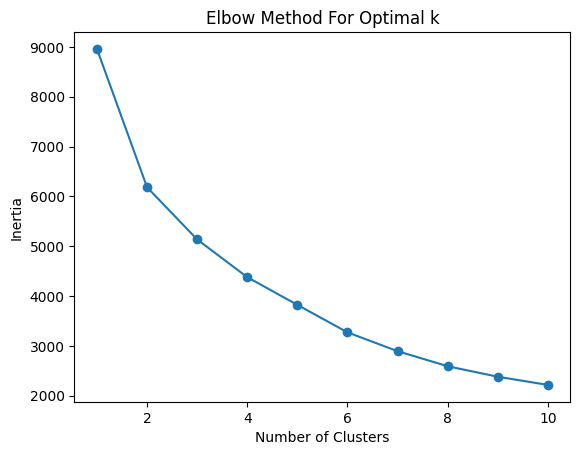

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    inertia.append(model.inertia_)

# Plot
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
df.groupby('Cluster')[['Age', 'Income', 'Total_Spend']].mean()


,Age,Income,Total_Spend
Cluster,,,
0,52.912651,40269.368976,171.125000
1,51.859348,35337.108062,218.830189
2,50.133047,76977.971030,1409.967811
3,70.483871,64138.397533,870.470588


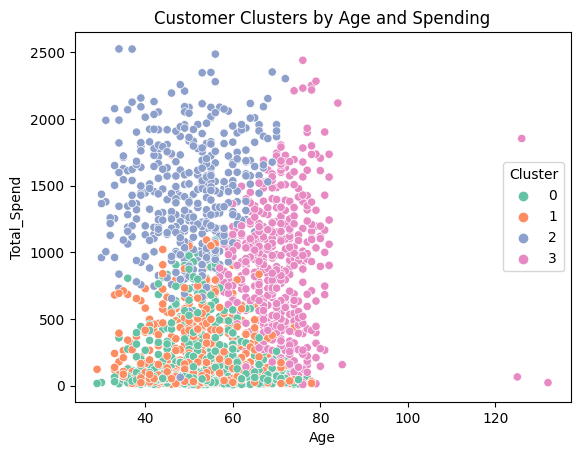

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Age', y='Total_Spend', hue='Cluster', palette='Set2')
plt.title("Customer Clusters by Age and Spending")
plt.show()


In [15]:

features = ['Age', 'Income', 'Total_Spend', 'Customer_Tenure_Days', 'Cluster']


target = 'Response'

X = df[features]
y = df[target]


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[362  17]
 [ 55  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       379
           1       0.45      0.20      0.28        69

    accuracy                           0.84       448
   macro avg       0.66      0.58      0.59       448
weighted avg       0.80      0.84      0.81       448



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


model_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
model_balanced.fit(X_train, y_train)

# Predict again
y_pred_balanced = model_balanced.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))


Confusion Matrix:
[[365  14]
 [ 55  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       379
           1       0.50      0.20      0.29        69

    accuracy                           0.85       448
   macro avg       0.68      0.58      0.60       448
weighted avg       0.81      0.85      0.82       448



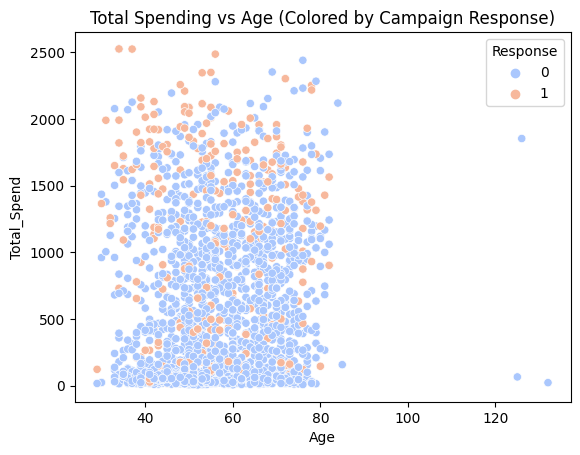

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Age', y='Total_Spend', hue='Response', palette='coolwarm')
plt.title("Total Spending vs Age (Colored by Campaign Response)")
plt.show()


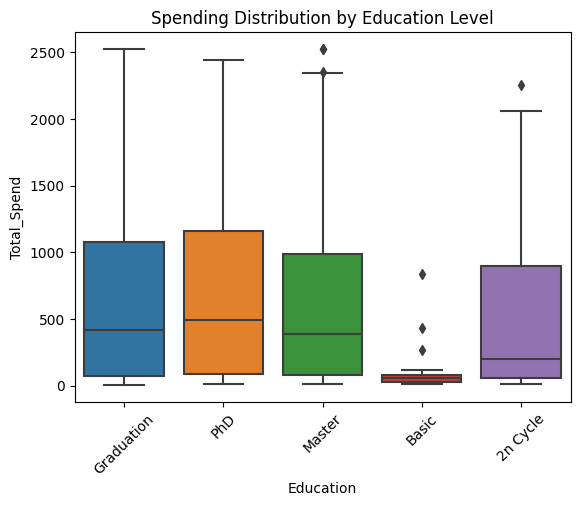

In [21]:
sns.boxplot(data=df, x='Education', y='Total_Spend')
plt.title("Spending Distribution by Education Level")
plt.xticks(rotation=45)
plt.show()


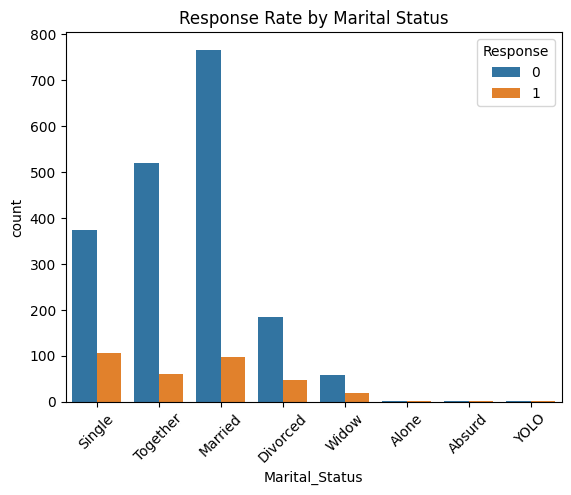

In [22]:
sns.countplot(data=df, x='Marital_Status', hue='Response')
plt.title("Response Rate by Marital Status")
plt.xticks(rotation=45)
plt.show()


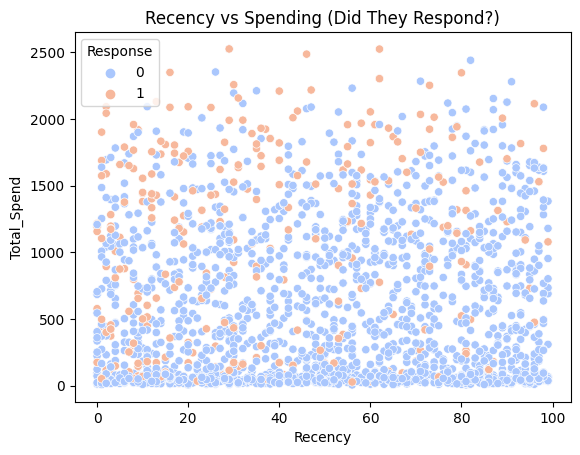

In [23]:
sns.scatterplot(data=df, x='Recency', y='Total_Spend', hue='Response', palette='coolwarm')
plt.title("Recency vs Spending (Did They Respond?)")
plt.show()
